#### I'm using this notebook to figure out what the missing parameters in the FakeAlmaden hamiltonian are. So far, I know that omegad0 is 0.1675.
----

Setting up pulse simulator:

1) switch to openpulse-sim branch of qiskit-aer, also include this pull request https://github.com/Qiskit/qiskit-aer/pull/451 and increase `nsteps` in qiskit-aer/qiskit/providers/aer/openpulse/solver/options.py (I upped 100x to 50000)

2) run `python setup.py build_ext --inplace`

3) `python ./setup.py bdist_wheel`

4) `cd dist` and `pip install` the wheel

5) `rm -rf /Users/pranavgokhale/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit` (replace with your username / site-packages location)

6) `ln -s /Users/pranavgokhale/Developer/qiskit/qiskit-aer/qiskit/ /Users/pranavgokhale/anaconda3/envs/QiskitDevenv/lib/python3.7/site-packages/qiskit` (tailor paths to your setup)

In [2]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#Import Qiskit classes classes
import qiskit
#from qiskit.providers.aer.noise import NoiseModel
#from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

import qiskit.pulse as pulse
import qiskit.pulse.pulse_lib as pulse_lib
from qiskit.compiler import assemble
import random
from qiskit.test.mock import FakeAlmaden

In [3]:
#Get a pulse configuration from the fake backend
backend_real = FakeAlmaden()
back_config = backend_real.configuration().to_dict()
system = pulse.PulseChannelSpec.from_backend(backend_real)

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [4]:
#Get pulse simulator backend
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

## Simulations

### These need to be run in sequential order

[Rabi Oscillation](#rabi)
Apply a pulse to Q0 and measure the population evoluation versus pulse amplitude

[Measurement Level 1 for the Readout Test](#readout_test)
<br> Prepare the |0> and |1> states and look at the measurement level 1 output 

[CR Oscillation](#cr)
<br> Look at the Q1 State when we drive Q0 at the frequency of Q1

[T1](#t1)
<br>Demonstrating noise with pulse

<a id='rabi'></a>
# Simulate a Rabi Oscillation

First, we are going to simulate a rabi oscillation, i.e., meausure the qubit state population versus the amplitude of a drive pulse. This is the same example that is in the tutorials.

### Build Pulse Schedule 

Build on qubit 0

In [5]:
cmd_def = qiskit.pulse.CmdDef.from_defaults(backend_real.defaults().cmd_def, backend_real.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend_real.configuration().meas_map[0])

In [64]:
schedule = cmd_def.get('x', qubits=[0])
schedule |= measure << schedule.duration
schedules = [schedule]

In [36]:
#qubit to use for exeperiment
qubit = 0
# exp configuration
exps = 161
shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.9, exps)
drive_samples = 512
drive_sigma = 32

# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                    amp=drive_amp, 
                                    sigma=drive_sigma, name='rabi_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='rabi_exp_amp_%s' % drive_amp)
    
    schedule += rabi_pulse(system.qubits[qubit].drive)
    schedule |= measure << schedule.duration
 
    schedules.append(schedule)

### Design the Hamiltonian

Let's build a transmon Hamiltonian with anharmonicity to test the Rabi oscillation and CR

In [65]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.04, 'omegad1': 2*np.pi*0.02,
                       'jq0q1': 0.01}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0

### Add Solver Settings

Any solver settings also does into the back_config

In [20]:
back_config['ode_options'] = {}

### Restrict the Qubits Used in the Simulation 

We can use a qubit whitelist (`qubit_list`) to restrict the set of qubits used in the solution. The pulse simulator will appropriately alter the Hamiltonian. To start let's assume the list contains the first 2 qubits.

In [22]:
back_config['qubit_list'] = [0,1]
#back_config['qubit_list'] = list(range(20))
#back_config['qubit_list'] = None

### Assemble the qobj with the backend config file and the qubit_list

We have to do this step twice to get the dressed frequencies for setting the LO's. Note here that we set `meas_level=1` and `meas_return=avg` which will return the average probability for the qubit to be in the |1> state.

In [10]:
rabi_qobj = assemble(schedules, backend_real, 
                     meas_level=1, meas_return='avg', 
                     memory_slots=2,
                     shots=shots, sim_config = back_config)

In [11]:
evals, estates = backend_sim.get_dressed_energies(rabi_qobj)

In [12]:
evals/2/np.pi

array([0.        , 4.85719783, 4.97174068, 9.82893851])

In [66]:
rabi_qobj = assemble(schedules, backend_real, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)

### Simulate

In [67]:
sim_result = backend_sim.run(rabi_qobj).result()

In [85]:
counts = []
omegad0s = np.linspace(0.166, 0.169, 10)
for omegad0 in omegad0s:
    back_config['hamiltonian']['vars']['omegad0'] = omegad0
    rabi_qobj = assemble(schedules, backend_real, 
                         qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                         shots=20000, sim_config = back_config)
    sim_result = backend_sim.run(rabi_qobj).result()
    counts.append(sim_result.get_counts().get('00000000000000000001', 0))

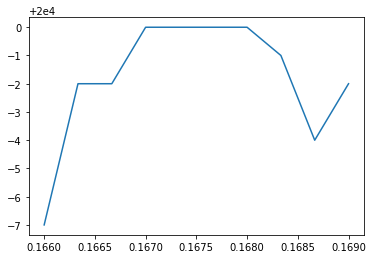

In [86]:
plt.plot(omegad0s, counts)

In [ ]:
omegad0 = 0.1675